In [1]:
import pandas as pd
import feature_engineering as fe
import sklift.datasets.datasets as sdd
from class_learners import SLearner, TLearner, CorrSTLearner
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from metric import extendedERUPT
import plots

<p><h1><b>Causal Machine Learning with Uplift Model</b></h1></p>
<p><h4><b>The objective:</b> find the intervention that maximises positive outcome  </h4> </p>
<p><h4><b>The data:</b> Hillstrom dataset</h4></p>

64,000 randomly chosen customers, who last purchased within 12 months, have been been subject to the following email intervention:
<ul>
    <li>1/3 were randomly chosen to receive an e-mail campaign featuring Men's merchandise.</li>
    <li>1/3 were randomly chosen to receive an e-mail campaign featuring Women's merchandise.</li>
    <li>1/3 were randomly chosen to not receive an e-mail campaign.</li>
</ul>
The the behaviour of the customers was tracked up to two weeks after the email campaign.

<i>I will use uplift models to determine the best email intervention for each customer: which email option (Men's merch, Women's merch, no email) suits best for which individual customer in order to maximise the number of visits of the online store.</i>

<h5><b>Columns with information of before the email intervention:</b></h5>
<ul>
    <li><b>Recency: </b>Months since last purchase.</li>
    <li><b>History_Segment:</b> Categorization of dollars spent in the past year.</li>
    <li><b>History:</b> Actual dollar value spent in the past year.</li>
    <li><b>Mens:</b> 1/0 indicator, 1 = customer purchased Mens merchandise in the past year.</li>
    <li><b>Womens:</b> 1/0 indicator, 1 = customer purchased Womens merchandise in the past year.</li>
    <li><b>Zip_Code:</b> Classifies zip code as Urban, Suburban, or Rural.</li>
    <li><b>Newbie:</b> 1/0 indicator, 1 = New customer in the past twelve months.</li>
    <li><b>Channel:</b> Describes the channels the customer purchased from in the past year.</li>    
</ul>
<h5><b>Intervention column:</b></h5>
<ul>
<li><b>Segment:</b></li>
<ul>
    <li>Mens E-Mail</li>
    <li>Womens E-Mail</li>
    <li>No E-Mail</li>
</ul>
</ul>

<h5><b>Columns tracking the activity of the customers up to two weeks after the email intervention:</b></h5>
<ul>
    <li><b>Visit:</b> 1/0 indicator, 1 = Customer visited website in the following two weeks.</li>
    <li><b>Conversion: </b>1/0 indicator, 1 = Customer purchased merchandise in the following two weeks.</li>
    <li><b>Spend:</b> Actual dollars spent in the following two weeks.</li>
</ul>
<br>
<p><h4><b>Causal Machine Learning:</b></h4></b>
<p>We would like to know how an individual customer will react given a specific intervention. However, we can't perform multiple interventions on the same individual in order to see how they'd react. The best approach is to use randomised controlled trial data (RCT): in these datasets, the interventions have been given randomly to a large enough number of individuals in order to deduce causal inference. </p>
<p>For example, there are two possible interventions: send an email or send no email. My objective is that I would like customers to visit my store. In my database, I look at customer A and wonder whether I should send an email. The RCT data should be a large enough pool of people so that at least two people, who are very similar to my customer A, had been subject to either intervention "email" or intervention "no email". My model (meta-learner) should give me the probabilities of success for each intervention on customer A, or - if looking at the uplift - the difference of these probabilities. This should give me enough insight to take an informed decision.</p>
<p>The hillstrom data set is a randomised controlled trial dataset: the interventions have been given randomly to a large enough number of customers to extract insights of causal inferences. </p>

In [2]:
hillstrom = sdd.fetch_hillstrom(target_col='visit', data_home=None, dest_subdir=None, download_if_missing=True, return_X_y_t=False)
hillstrom.keys()

dict_keys(['data', 'target', 'treatment', 'DESCR', 'feature_names', 'target_name', 'treatment_name'])

In [3]:
hillstrom_features = hillstrom['data']
hillstrom_features.head(2)

,recency,history_segment,history,mens,womens,zip_code,newbie,channel
0,10,2) $100 - $200,142.44,1,0,Surburban,0,Phone
1,6,3) $200 - $350,329.08,1,1,Rural,1,Web


In [4]:
hillstrom_target = hillstrom['target']
hillstrom_treatment = hillstrom['treatment']
hillstrom_treatment.head(2)

0    Womens E-Mail
1        No E-Mail
Name: segment, dtype: object

<p><h3><b>The data set:</b></h3></p>
What is the over all most successful intervention? What is the ratio of "visit"/"no visit" of all other features?

In [5]:
df_hillstrom = pd.concat([hillstrom_features,hillstrom_treatment,hillstrom_target], axis = 1)

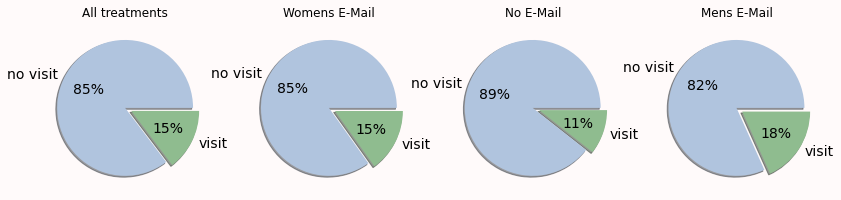

In [6]:
plots.pie_plots(df_hillstrom,'segment','visit')

"Mens E-Mail" is the most successful intervention, leading to 18% of purchases. Unfortunately, none of the interventions is working particularly well. This leaves a very uneven distribution of "visit"/"no visit", which will affect the ml models.

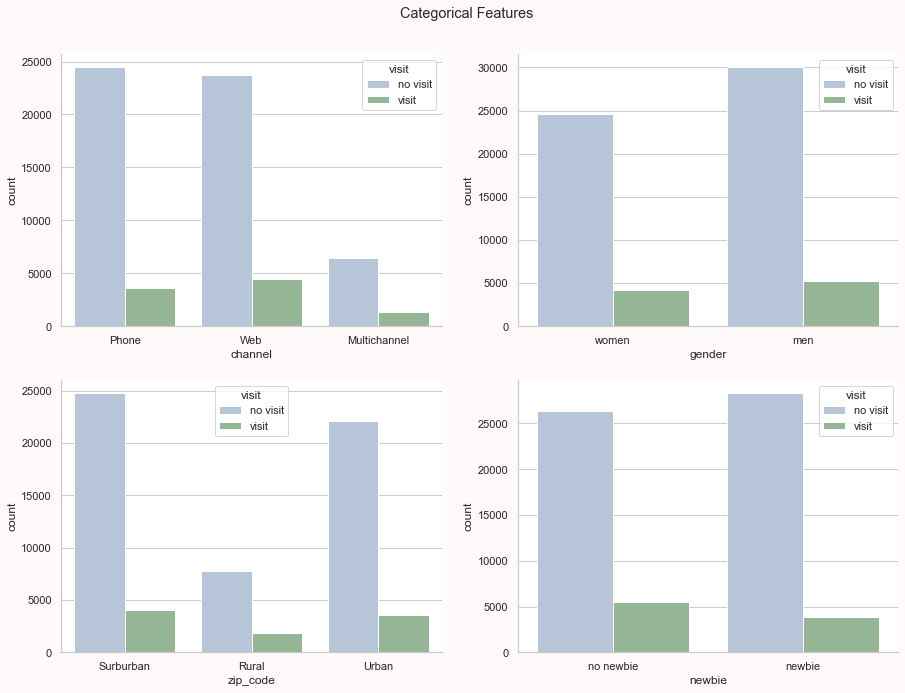

In [7]:
plots.plot_categorical(df_hillstrom)

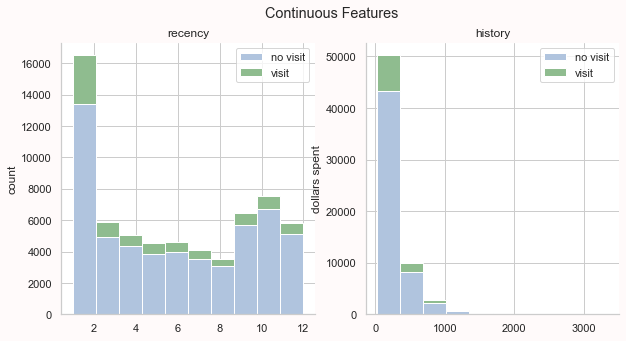

In [8]:
plots.plot_continuous(df_hillstrom)

All the features display a more or less equal share of "visit".

<p><h3><b>Feature engineering</b></h3></p>
<p>Change the following columns to datatype `category` and create dummies:
<ul>
    <li>zip_code</li>
    <li>channel</li>
</ul></p>
<p>Mapping the values ("no email", "Women's email", and "Men's email") of the treatment to 0, 1, and 2.</p>
<p>Dropping the column `history_segment`: the columns 'history' and 'history_segment' display the same information. As 'history' is more detailled, I will keep this column.</p>

In [9]:
hillstrom_features = fe.feature_engineering(hillstrom_features)
hillstrom_features.head(2)

,recency,history,mens,womens,newbie,zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,channel_Phone,channel_Web
0,0.603876,-0.194501,1,0,0,0,1,0,0,1,0
1,0.033679,0.169807,1,1,1,1,0,0,0,0,1


In [10]:
hillstrom_treatment = fe.treatment_category(hillstrom_treatment)
hillstrom_treatment.head(2)

0    1
1    0
Name: segment, dtype: int64

<p><h3><b>S-Learner, T-Learner, and correlated ST-Learner  </b></h3></p>
Meta-learners are frameworks to estimate the Conditional Average Treatment Effect (CATE) or "Uplift" using any machine learning estimators. In this case, I will use Meta-learners to build a recommendation machine based on uplift models. I will use the S-, T-, and correlated ST-learner as base models. As estimators I will use XGBoost, Random Forest, and Logistic Regression for each learner. Instead of computing the uplift of each email intervention, I will compare the probabilities of each intervention and opt for the treatment with the highest probability.<br>
The following explanations assume binary treatment options.
<p><h4><b>S-Learner:</b></h4></p>
<p>Contrary to the T-learner, the S-learner uses only one machine learning model (single base).
$$
\mu = E[Y|X=x, W=w]
$$
with $\mu$ being average outcome, $Y$ the outcome, $X$ the covariate, and $W$ the treatment effect.</p>
<p>The CATE is </p>
$$\tau(x) = \hat{\mu}(x,w = 1) - \hat{\mu}(x,w = 0).$$
<p><h4><b>T-Learner:</b></h4></p>
<p>The T-learner uses a model for each treatment option:
$$\mu_{0} = E[Y(0)|X=x],\quad \mu_{1} = E[Y(1)|X=x]$$.</p>
<p>The CATE is $\tilde{\tau} = \mu_{1}(x) - \mu_{0}(x)$.</p>
<p><h4><b>correlated ST-Learner:</b></h4></p>
<p>The correlated ST-learner is a boosted mixture of both the S- and the T-learner. The train and test data will be prepared according to the T- and S-learner, respectively.There are four models to be considered: the base model and the three booster models. The base model is an xgboost on the whole train data. The three booster models are models for $$\mu = E[Y(i)|X=x,W=i]$$ each boosted from the base model, where $i = 0,1$. The CATE is the same as for the S-learner. </p>
<p>Note that this is a summary of the project. Some of the fine-tuning is not shown in this notebook</p>
<hr>
<h5><b>S-Learner:</b></h5>


In [11]:
s = SLearner(hillstrom_features, hillstrom_treatment, hillstrom_target)
best_proba_logreg_S = s.get_proba(LogisticRegression,random_state = 42)
best_proba_randfor_S = s.get_proba(RandomForestClassifier,max_depth=2,min_samples_leaf=2, random_state=42)
best_proba_xgb_S = s.get_proba(xgb.XGBClassifier, seed=42, use_label_encoder=False, max_depth=1,eval_metric="logloss",)

In [12]:
S_Learner = pd.DataFrame({'logreg':best_proba_logreg_S,'rand_for':best_proba_randfor_S, 'xgb' :best_proba_xgb_S})
S_Learner.apply(lambda x: x.value_counts()).T.stack()

logreg    2    32000
rand_for  2    32000
xgb       2    32000
dtype: int64

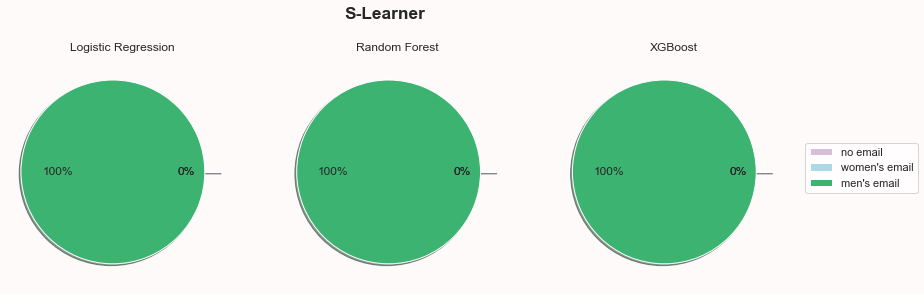

In [13]:
lst = ['logreg','rand_for','xgb']
plots.pie_plot_best_outcome(S_Learner,lst,'S-Learner')

Unfortunately, only 15% of interventions lead to a visit of the website. Of these 15%, most of the interventions are "Men's email" (Number 2). Hence, it is not surprising that the S learner only picks treatment 2 and doesn't fare that badly (as can be seen in the next section).

<h5><b>T-Learner:</b></h5>

In [14]:
t = TLearner(hillstrom_features, hillstrom_treatment, hillstrom_target)
best_proba_logreg_T = t.get_proba(LogisticRegression, 'segment', random_state = 42)
best_proba_randfor_T = t.get_proba(RandomForestClassifier,'segment', max_depth=2,min_samples_leaf=2, random_state=42)
best_proba_xgb_T = t.get_proba(xgb.XGBClassifier, 'segment', seed = 42, use_label_encoder=False, max_depth=1,eval_metric="logloss")

In [15]:
T_Learner = pd.DataFrame({'logreg':best_proba_logreg_T,'rand_for':best_proba_randfor_T, 'xgb' :best_proba_xgb_T})
T_Learner.apply(lambda x: x.value_counts()).T.stack()

logreg    0        1.0
          1    12179.0
          2    19820.0
rand_for  1     6408.0
          2    25592.0
xgb       0       56.0
          1    11145.0
          2    20799.0
dtype: float64

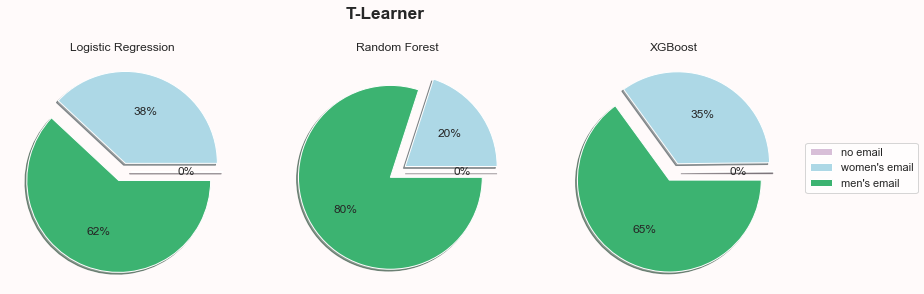

In [16]:
lst = ['logreg','rand_for','xgb']
plots.pie_plot_best_outcome(T_Learner,lst,'T-Learner')

<h5><b>Correlated ST-Learner:</b></h5>

In [17]:
ct = CorrSTLearner(hillstrom_features, hillstrom_treatment, hillstrom_target)
ct.prepare_data()
best_proba_xgb_cT = ct.get_proba(seed=42, use_label_encoder=False, max_depth=1,eval_metric="logloss")
corrST_Learner = pd.DataFrame({'xgb' :best_proba_xgb_cT})
corrST_Learner.apply(lambda x: x.value_counts()).T.stack()

xgb  2    20588
     1    11371
     0       41
dtype: int64

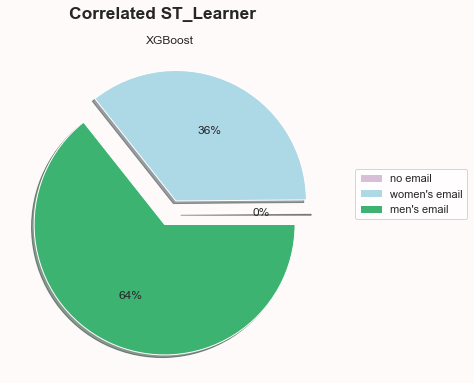

In [18]:
plots.pie_plot_xgb(corrST_Learner,'Correlated ST_Learner')


<p><h3><b>Extended ERUPT metric:</b></h3></p>
<p>The <a href="https://medium.com/building-ibotta/erupt-expected-response-under-proposed-treatments-ff7dd45c84b4">ERUPT metric</a> poses a valid alternative to the commonly used Qini metric. In summary, it filters for events, where we proposed the same treatments as the test set, and subsequently computes the ratio between the number of successes and the size of the filtered set:
$$ \frac{\sum_{i}y_{i}I(w(x_{i} = t_{i})}{\sum_{i}(w(x_{i})+t_{i})}$$
where $w$ is the assigned treatment, $t$ the treatment given in the test set, and $y$ the outcome.
</p>
<p>An interesting aspect of the ERUPT metric is that by filtering for matching treatments and counting the successfull events, we aim to propose a different treatment in case of a unsuccessful event.</p>
<p>I extended the ERUPT metric by comparing my ERUPT value to the ERUPT value of randomised treatments: I shuffle the treatments of my model and allocate them randomly. I compute the ERUPT value of the random allocation and compare it to the ERUPT value of my model. I repeat the shuffling 500 times. Should the random ERUPT values exceed the ERUPT model of my model, I can conclude that my model is performing worse than randomly distributed treatments.</p>
<p>Note that I randomise the proposed treatments of my models. If, e.g., a model proposes only one treatment for all events, the randomised ERUPT value will coincide with the ERUPT value of my model.</p>
<hr>
<h5><b>S-Learner:</b></h5>

In [19]:
S_Learner_values = {}

In [20]:
ee = extendedERUPT(best_proba_logreg_S,s.test_treatment, s.y_test)
S_Learner_values['logreg'] = ee.get_ERUPT_with_benchmark()

ERUPT model: 0.1827, sum of y: 1943, number of rows: 10635
ERUPT benchmark: 0.1827, sum of y: 1943, number of rows: 10635
Difference of ERUPT(model) and ERUPT(benchmark): -0.0000


In [21]:
ee = extendedERUPT(best_proba_randfor_S,s.test_treatment, s.y_test)
S_Learner_values['randfor'] = ee.get_ERUPT_with_benchmark()

ERUPT model: 0.1827, sum of y: 1943, number of rows: 10635
ERUPT benchmark: 0.1827, sum of y: 1943, number of rows: 10635
Difference of ERUPT(model) and ERUPT(benchmark): -0.0000


In [22]:
ee = extendedERUPT(best_proba_xgb_S,s.test_treatment, s.y_test)
S_Learner_values['xgb'] = ee.get_ERUPT_with_benchmark()

ERUPT model: 0.1827, sum of y: 1943, number of rows: 10635
ERUPT benchmark: 0.1827, sum of y: 1943, number of rows: 10635
Difference of ERUPT(model) and ERUPT(benchmark): -0.0000


<h5><b>T-Learner:</b></h5>

In [23]:
T_Learner_values = {}

In [24]:
ee = extendedERUPT(best_proba_logreg_T,t.test_treatment, t.y_test)
T_Learner_values['logreg'] = ee.get_ERUPT_with_benchmark()

ERUPT model: 0.1791, sum of y: 1916, number of rows: 10697
ERUPT benchmark: 0.1700, sum of y: 1811, number of rows: 10650
Difference of ERUPT(model) and ERUPT(benchmark): 0.0091


In [25]:
ee = extendedERUPT(best_proba_randfor_T,t.test_treatment, t.y_test)
T_Learner_values['randfor'] = ee.get_ERUPT_with_benchmark()

ERUPT model: 0.1821, sum of y: 1936, number of rows: 10631
ERUPT benchmark: 0.1760, sum of y: 1873, number of rows: 10641
Difference of ERUPT(model) and ERUPT(benchmark): 0.0061


In [26]:
ee = extendedERUPT(best_proba_xgb_T,t.test_treatment, t.y_test)
T_Learner_values['xgb'] = ee.get_ERUPT_with_benchmark()

ERUPT model: 0.1791, sum of y: 1913, number of rows: 10681
ERUPT benchmark: 0.1710, sum of y: 1821, number of rows: 10649
Difference of ERUPT(model) and ERUPT(benchmark): 0.0081


<h5><b>Correlated ST-Learner:</b></h5>

In [27]:
cST_Learner_values = {}

In [28]:
ee = extendedERUPT(best_proba_xgb_cT,ct.test_treatment, ct.y_test)
cST_Learner_values['xgb'] = ee.get_ERUPT_with_benchmark()

ERUPT model: 0.1802, sum of y: 1922, number of rows: 10664
ERUPT benchmark: 0.1708, sum of y: 1819, number of rows: 10650
Difference of ERUPT(model) and ERUPT(benchmark): 0.0094


<p>The S-learner performs best by suggesting only "Mens E-Mail" for each customers. This is not very surprising considering how unevenly distributed "visit"/"no visit" is and how "Mens E-Mail" is the most effective treatment.</p>

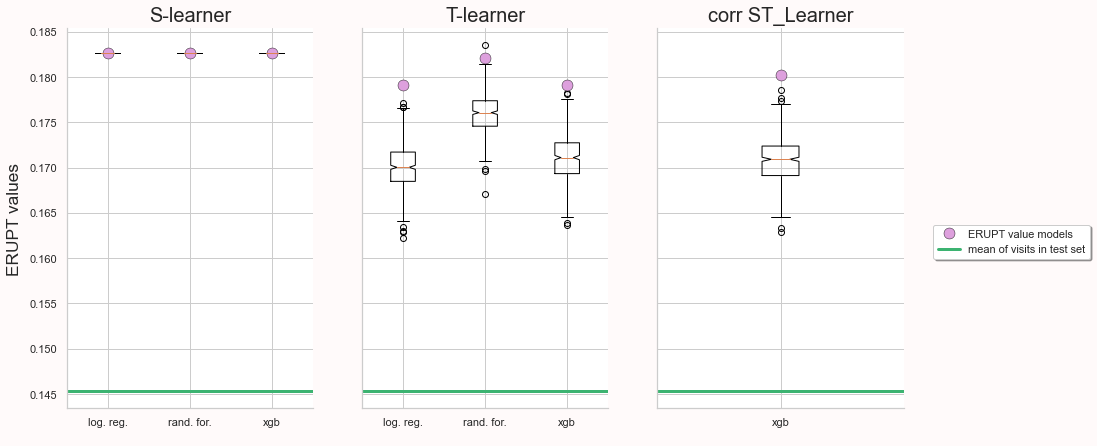

In [29]:
plots.plot_ERUPT(S_Learner_values,T_Learner_values,cST_Learner_values)

<p>The boxplot in the plots represent the distribution of the ERUPT values of the random distribution of the the proposed treatments per model. Because the S-learner proposes only the treatment "Mens E-Mail", every ERUPT value of a random distribution of (the same) treatement will be the same. Hence, the boxplot will be reduced to a line. </p>
<p>However, the S-learner achieves the highest score despite its monotone treatment suggestions. It is closely followed by the T-learner using the random forest classifier.</p>
<p>Improvements can probably be achieved by further fine tuning of the parameters, which I leave for the interested reader to test.</p>